# Fashion MNIST CNN Model

In [2]:
# references: https://www.digitalocean.com/community/tutorials/writing-cnns-from-scratch-in-pytorch

# load libraries
import torch
from torch.utils.data import random_split, DataLoader
import torch.nn as nn
from torchvision import datasets, transforms

# determine whether to use GPU or CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# define variables for the model
batch_size = 64
num_classes = 10
learning_rate = 0.001
num_epochs = 27

## Data Preprocessing

In [4]:
# Normalize to [0, 1]
all_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.0,), (1.0,))
])

# Load the training dataset
full_train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=all_transforms)

# Load the testing dataset
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=all_transforms)

# Split into training and validation sets
validation_size = 10000
train_size = len(full_train_dataset) - validation_size
train_dataset, validation_dataset = random_split(full_train_dataset, [train_size, validation_size])

# Create data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 26.4M/26.4M [00:02<00:00, 10.4MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 167kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.08MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 21.2MB/s]


### Explore the Dataset

In [5]:
# Print basic information
print("Training set size:", len(train_dataset))
print("Validation set size:", len(validation_dataset))
print("Test set size:", len(test_dataset))

print("Image shape:", train_dataset[0][0].shape)
print("Number of classes:", len(full_train_dataset.classes))

#checking class balance.
train_labels = [label for _, label in train_dataset]
validation_labels = [label for _, label in validation_dataset]
test_labels = [label for _, label in test_dataset]

print("training label distribution:", torch.bincount(torch.tensor(train_labels)))
print("validation label distribution:", torch.bincount(torch.tensor(validation_labels)))
print("testing label distribution:", torch.bincount(torch.tensor(test_labels)))

Training set size: 50000
Validation set size: 10000
Test set size: 10000
Image shape: torch.Size([1, 28, 28])
Number of classes: 10
training label distribution: tensor([4903, 5023, 4978, 5028, 5014, 5011, 5017, 5013, 5023, 4990])
validation label distribution: tensor([1097,  977, 1022,  972,  986,  989,  983,  987,  977, 1010])
testing label distribution: tensor([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000])


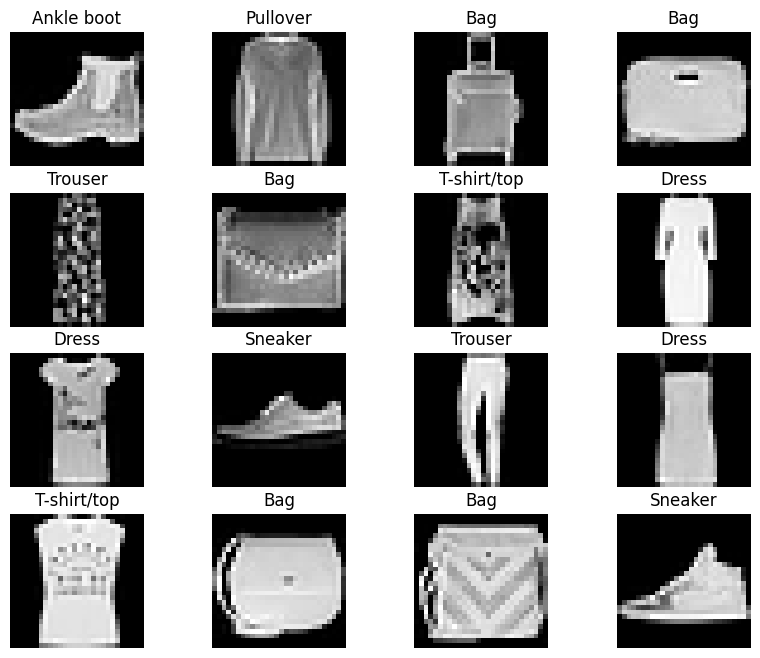

In [6]:
import matplotlib.pyplot as plt

# Get a batch of images from the training loader
view_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
images, labels = next(iter(view_loader))

# Display images
plt.figure(figsize=(10, 8))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(full_train_dataset.classes[labels[i]])
    plt.axis('off')
plt.show()

## Building Model

In [7]:
class ConvNet(nn.Module):
    # define layers and order in CNN
    def __init__(self, num_classes):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(64 * 7 * 7, 128) # 64 channels, 7x7 feature map
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)

    # pass data across layers
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.pool1(out)

        out = self.conv3(out)
        out = self.conv4(out)
        out = self.pool2(out)

        # reshape output to match input of fully connected layer
        out = out.reshape(out.size(0), -1)

        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        return out

## Setting Hyperparameters

In [8]:
model = ConvNet(num_classes).to(device)

# set loss function
criterion = nn.CrossEntropyLoss()

# Set optimizer with optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)

total_step = len(train_loader)

## Training Model

In [9]:
loss_values = []  # List to store training loss values
val_loss_values = []  # List to store validation loss values
val_accuracy_values = []  # List to store validation accuracy values

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0  # Accumulate training loss for the epoch

    for i, (images, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Compute average training loss for the epoch
    avg_loss = running_loss / len(train_loader)
    loss_values.append(avg_loss)

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in validation_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Compute average validation loss and accuracy
    avg_val_loss = val_running_loss / len(validation_loader)
    val_accuracy = 100 * correct / total
    val_loss_values.append(avg_val_loss)
    val_accuracy_values.append(val_accuracy)

    print('Epoch [{}/{}], Loss: {:.4f}, Val Loss: {:.4f}, Val Accuracy: {:.2f}%'.format(epoch + 1, num_epochs, avg_loss, avg_val_loss, val_accuracy))

Epoch [1/27], Loss: 1.2583, Val Loss: 0.6618, Val Accuracy: 76.12%
Epoch [2/27], Loss: 0.5758, Val Loss: 0.5140, Val Accuracy: 81.41%
Epoch [3/27], Loss: 0.4841, Val Loss: 0.4950, Val Accuracy: 81.96%
Epoch [4/27], Loss: 0.4308, Val Loss: 0.4491, Val Accuracy: 83.58%
Epoch [5/27], Loss: 0.3987, Val Loss: 0.4372, Val Accuracy: 83.68%
Epoch [6/27], Loss: 0.3776, Val Loss: 0.3956, Val Accuracy: 85.53%
Epoch [7/27], Loss: 0.3599, Val Loss: 0.3772, Val Accuracy: 86.74%
Epoch [8/27], Loss: 0.3481, Val Loss: 0.3841, Val Accuracy: 85.75%
Epoch [9/27], Loss: 0.3389, Val Loss: 0.3741, Val Accuracy: 86.55%
Epoch [10/27], Loss: 0.3254, Val Loss: 0.3480, Val Accuracy: 87.13%
Epoch [11/27], Loss: 0.3159, Val Loss: 0.3429, Val Accuracy: 87.53%
Epoch [12/27], Loss: 0.3096, Val Loss: 0.3292, Val Accuracy: 87.99%
Epoch [13/27], Loss: 0.3008, Val Loss: 0.3366, Val Accuracy: 87.86%
Epoch [14/27], Loss: 0.2932, Val Loss: 0.3276, Val Accuracy: 88.25%
Epoch [15/27], Loss: 0.2863, Val Loss: 0.3234, Val Accura

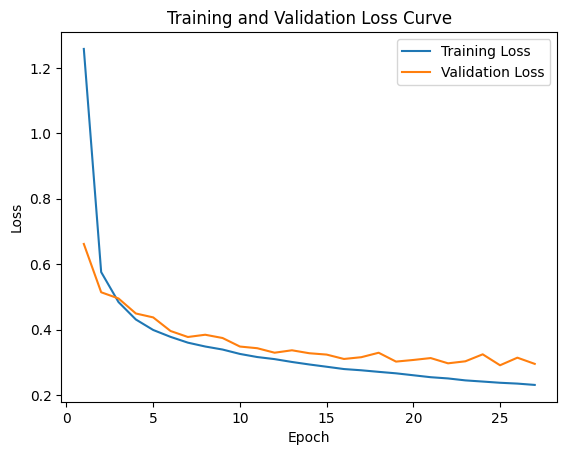

In [10]:
# Plot the training and validation loss curves AFTER the loop
plt.plot(range(1, num_epochs + 1), loss_values, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_loss_values, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.show()

## Evaluating Model on Test Dataset

In [11]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the {} test images: {:.2f} %'.format(len(test_dataset), 100 * correct / total))

Accuracy of the network on the 10000 test images: 89.35 %


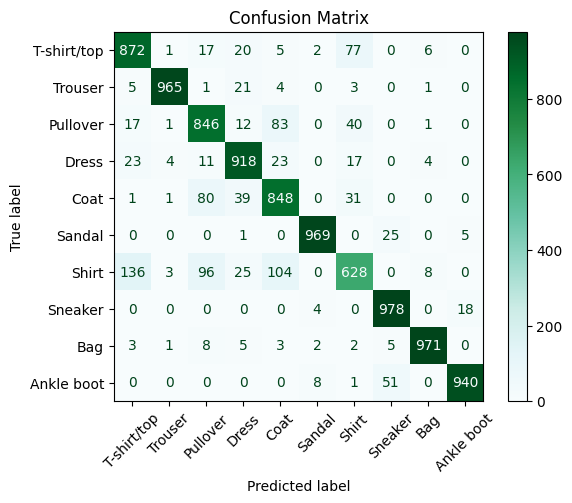

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Collect true and predicted labels
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Display confusion matrix with adjustments
fig, ax = plt.subplots()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=full_train_dataset.classes)
disp.plot(cmap='BuGn', ax=ax)
plt.title('Confusion Matrix')
plt.xticks(rotation=45)  # Rotate x-axis labels to prevent overlap
plt.show()

## Experimentation & Improvements